# 학습목표
- 머신러닝을 이용한 텍스트 분류 (text Classification) 중 다중분류 수행하기
- F1 score와 confusion matrix 출력해보기
- 여러 머신러닝 모델에 대해서 성능 비교하기
- 단어 수에 따른 성능 비교해보기

# 데이터 정보
- 로이터 뉴스 데이터
- 총 46개의 카테고리로 구분되며, 해당뉴스의 카테고리를 예측하기 위한 데이터
- 이미 데이터가 sequence로 인코딩 되어있음.
- 그래서 이미 빈도수가 높은 순으로 단어가 sort 되어있는 상태라 num_words 수만큼이 빈도수별로 끊김.

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# 데이터 불러오면서 데이터셋 나누기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

In [3]:
word_index = reuters.get_word_index()
word_freq = {k: (v, word_index.get(k)) for k, v in sorted(((v, k) for (k, v) in word_index.items()), reverse=True)}

# 앞에서 top10위 단어들
for i, (freq, idx) in enumerate(word_freq.items()):
    if i == 10:
        break
    print(f"{idx}\t{freq}")
print("="*30)
    
# 뒤에서 10위 
num_words = 10000
for i, (freq, idx) in enumerate(word_freq.items()):
    if i > num_words-10:
        print(f"{idx}\t{freq}")
    if i == num_words:    
        break

('northerly', None)	30979
('jung', None)	30978
('figueras', None)	30977
('capco', None)	30976
('recirculation', None)	30975
("guard's", None)	30974
('odilon', None)	30973
('staalfabrieken', None)	30972
('corporacion', None)	30971
('clampdown', None)	30970
('attendence', None)	20988
('19p', None)	20987
('teapa', None)	20986
('teape', None)	20985
('menswear', None)	20984
("centronic's", None)	20983
('expropriated', None)	20982
('displays', None)	20981
('fractionation', None)	20980
('kemper', None)	20979


In [4]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [5]:
print(x_train[0])
print(x_test[0])
print(y_train[0])
print(y_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]
3
3


In [6]:
# 총 카테고리 갯수 알아보기

print(len(np.unique(y_train)))
print(len(np.unique(y_test)))

46
46


# 0. 데이터 분포 확인하기

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


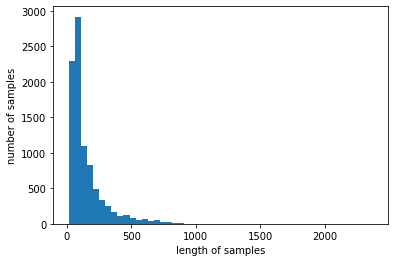

In [7]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

길이가 가장 긴 뉴스의 길이는 2,376입니다. 평균 길이는 145구요. 아무래도 길이가 가장 긴 뉴스의 길이가 다른 뉴스에 비해 유독 긴 편인 것 같습니다. 시각화된 그래프의 분포로 봤을 때 500~1,000 사이의 길이를 가지는 뉴스도 일부 있어 보이죠?

우리가 맞춰야 하는 클래스의 분포를 확인해볼까요? 모델의 성능에 영향을 줄 수 있는 요소이기 때문에 실제로 모든 클래스가 다 존재는 하는 것인지, 또 어떤 클래스가 유독 많은지와 같은 것들을 사전에 확인해 보아야 합니다.

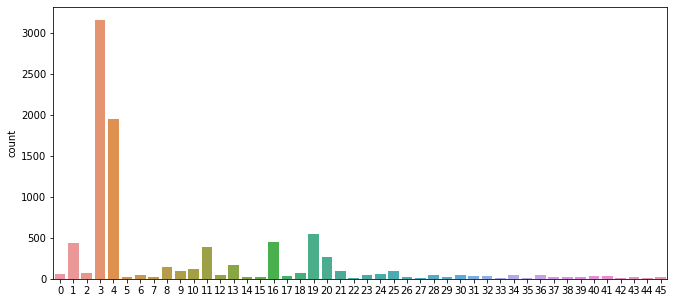

In [8]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

이 뉴스 데이터는 3번, 4번 클래스가 대부분을 차지하고 있습니다. 그 뒤로는 19번, 16번, 1번, 11번 등이 높은 분포를 가지고 있네요. 시각화를 통해 어떤 클래스가 많고, 적은 것을 쉽게 확인할 수는 있었지만 수치적으로 정확히 몇 개인지도 출력해보겠습니다.

In [9]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


3번, 4번 클래스의 경우에는 각각 3,159개와 1,949개가 존재합니다. 그 뒤로는 549개로 19번 클래스가 세 번째로 많고, 16번 클래스가 444개로 네 번째로 많네요. 이렇게 각 클래스가 몇 개가 존재하는지도 확인해 봤어요.

# 1. 데이터 굳이 텍스트 원본으로 복원하기

이번에는 조금은 일반적이지 않은 전처리를 해볼 겁니다! 이 데이터는 이미 어느 정도 전처리가 되어서 각 단어가 정수 시퀀스로 변환된 채 제공되고 있다고 언급했었어요. 하지만 일반적인 상황이라면 텍스트를 숫자로 수치화하는 과정을 처음부터 해야 합니다.

그래서 우리는 여기서 정수 시퀀스로 변환된 데이터를 '굳이' 다시 텍스트로 돌려보겠습니다.

로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공합니다. 이를 word_index로 저장해보겠습니다.

In [10]:
# word_index = reuters.get_word_index() # 위에서 했음
print(word_index['the'])
print(word_index['it'])

1
13


그런데 지금 우리가 해야 할 일은 현재 갖고 있는 정수 시퀀스로 되어 있는 데이터를 텍스트 형태로 되돌려야 하는 일이므로 사실 word_index보다는 정수로부터 단어를 얻을 수 있는 index_word가 필요합니다.

그런데 이 데이터에는 숨겨진 비밀이 하나 있는데, 뉴스 데이터 안에서 단어 'the'는 사실 1번이 아니라 4번 단어입니다. 그리고 단어 'it'은 사실 13번 단어가 아니라 16번 단어입니다. 왜냐하면 0번, 1번, 2번은 사실 자연어 처리에 쓰이는 특별한 토큰들을 위해 맵핑된 번호이기 때문입니다. (각각 <pad>, <sos>, <unk>라는 토큰을 나타냅니다.)

그렇기 때문에, 다른 단어들도 word_index의 결과로 나오는 숫자에 3을 더해주어야 단어가 실제로 맵핑된 인덱스 값이 나옵니다. 이건 로이터 뉴스 데이터가 정의한 일종의 약속입니다.

In [11]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [12]:
print(index_to_word[4])   # 1+3
print(index_to_word[16])  # 13+3

the
it


위에서 0번, 1번, 2번 인덱스에는 각각 <pad>, <sos>, <unk>라는 특별한 토큰이 맵핑되어 있다고 했죠? 그래서 만들어진 index_to_word에 이 토큰들도 추가해주어야 진짜 index_to_word가 완성됩니다.

In [13]:
# 위에 3씩 미뤄놓은 index_to_word 앞에 0,1,2 추가해주기

for index, token in enumerate(("<pad>","<sos>","<unk>")):
    index_to_word[index]=token    

In [14]:
# 첫번째 기사 복원하기

print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


첫 번째 훈련용 뉴스 기사가 정수 시퀀스에서 텍스트로 복원되었습니다. 이 데이터도 어느 정도 전처리가 된 상태라서, 자연스럽게 읽히지는 않습니다. 하지만 문맥을 가진 텍스트이기 때문에, 이 데이터를 가지고 머신러닝을 시작해도 별 무리는 없어 보입니다.

복원된 첫 번째 훈련용 뉴스 기사에 특별 토큰인 <sos>와 <unk>가 보이는데, <sos>는 텍스트 분류를 위한 토큰이 아니므로 크게 신경을 쓰지 않아도 됩니다. 하지만 <unk>는 자연어 처리 전반에서 쓰이는 특별 토큰이므로 이에 대해서는 이해할 필요가 있습니다.

## OOV 문제와 UNK 토큰
기계가 알고 있는 단어들의 집합을 단어장(Vocabulary)이라고 합니다. 기계가 미처 배우지 못한 모르는 단어를 OOV(Out-Of-Vocabulary) 또는 UNK(Unknown) 이라고 표현합니다. 어떤 단어를 기계가 모르는 단어로 판단하면, 기계는 해당 단어를 전부 <unk>라는 일관된 특별 토큰으로 변환합니다.

우리가 가장 맨 처음 사용했던 코드를 상기해 봅시다.

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
    
    
num_words=10000는 정수 번호가 10,000이 넘는 단어들을 자동으로 \<unk> 토큰으로 처리합니다. 로이터 뉴스 데이터에서 \<unk>은 정수 2번을 가지도록 약속돼 있으므로 데이터를 로드하는 과정에서 정수 번호가 10,000이 넘는 단어들은 전부 정수 2로 변환되어서 로드가 되었던 것입니다.

Q1. 로이터 뉴스 데이터 중 [4, 587, 23, 133, 6, 30, 515]인 정수 시퀀스가 있습니다. 현재 우리가 가진 index_word를 사용하여 이 정수 시퀀스를 텍스트 시퀀스로 변환해보세요.

In [15]:
a = [4, 587, 23, 133, 6, 30, 515]
print(' '.join([index_to_word[index] for index in a]))
# print(' '.join([index_to_word[index] for index in x_train[0]]))

the transaction is expected to be completed


Q2. 데이터를 로드하기 전 로이터 뉴스 데이터에는 다음과 같은 정수 시퀀스가 있었다고 해봅시다.
[4, 12000, 23, 133, 6, 30, 515]
이 데이터를 로드한 데이터에서 우리가 저 문장을 출력하면 다른 정수 시퀀스가 출력되는데요. 해당 정수 시퀀스를 추측해 보세요.

In [16]:
a = [4, 12000, 23, 133, 6, 30, 515]
print(' '.join([index_to_word[index+3] for index in a]))
print([index_to_word[index+3] for index in a])
# 사실 12000은 num_words=10000에서 잘려 OOV가 되므로, <unk>=2로 매칭됨
# 번역된 단어에도 해당단어는 OOV라 아예 출력이 안됨.

in responsibilities cts under and will approval
['in', 'responsibilities', 'cts', 'under', 'and', 'will', 'approval']


In [17]:
# 전체 train 데이터 복원하기

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print("x_train 데이터 갯수 :",len(x_train))

x_train 데이터 갯수 : 8982


In [18]:
# 전체 test 데이터 복원하기

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print("x_test 데이터 갯수 :",len(x_test))

x_test 데이터 갯수 : 2246


In [19]:
print(x_train[:1])
print("="*30)
print(x_test[:1])

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3']
['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital pro

# 2. 벡터화 하기

텍스트 데이터가 있을 때, 모델의 입력으로 넣기 위해서는 우선 각 문서를 벡터화할 필요가 있습니다. 항상 그런 것은 아니지만, 일반적으로 텍스트 분류를 할 모델로 인공 신경망을 사용하는 경우, 벡터화 방법 또한 인공 신경망을 사용하는 것이 보편적입니다. Word Embedding, Document Embedding, Contextual Embedding 등의 다양한 벡터화 방법이 존재하는데요.

이번 실습에서는 딥러닝이 아닌 머신러닝 방법을 사용하여 텍스트 분류를 진행할 예정이기 때문에 벡터화 방법도 인공 신경망이 아닌 방법을 사용하겠습니다. 저희가 사용할 벡터화 방법은 Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬입니다.

Bag of Words 가설과 이를 통해 만드는 DTM에 대한 정의는 아래의 링크를 통해 알아보겠습니다.

Q3. (O/X 퀴즈) 총 3개의 문서가 있습니다. 단어 단위로 토크나이징을 하였을 때, 첫 번째 문서의 길이가 3, 두 번째 문서의 길이가 2, 세 번째 문서의 길이가 4로 나왔습니다. 이 세 개의 문서로부터 만든 DTM의 열의 개수는 9입니다. (O/X) 
- 모름. 9단어 중 중복이 있으면 더 적을 수 있음. 9개 이하가 정답.

Q4. DTM을 기반으로 문서를 군집, 혹은 분류한다면 같은 단어가 많이 등장한 문서들일수록 그 유사도가 높다고 판단할 수 있습니다. 군집이나 분류 시에 이러한 가정을 사용한다면 성능을 저하시킬 수 있는 요소는 무엇일까요?
- 불용어는 모든 문서에 자주 등장하지만 실제로 중요한 의미를 가지지는 않으므로 이러한 가정에서는 성능 저하의 원인이 될 수 있습니다.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

Document Term Matrix, DTM은 사이킷런의 CountVectorizer()를 통해서 생성할 수 있습니다.

DTM을 생성하고, DTM의 크기를 확인해보겠습니다.

In [21]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


훈련용 뉴스의 수가 총 8,982개였기 때문에 DTM의 행의 개수는 8,982개가 됩니다. 그런데 이상한 점은 앞에서 데이터를 로드할 때, num_words=10,000이라는 값을 사용했음에도 DTM 열의 개수는 이보다 현저하게 적은 9,670개밖에 되지 않습니다. 그 이유는 DTM이 자체적인 규칙에 따라서 불필요하다고 판단하는 토큰들을 제거하기 때문입니다.

DTM 행렬을 이어서 TF-IDF 행렬을 만들어보겠습니다. TF-IDF 행렬은 퀴즈 4에서 알아본 DTM의 단점을 보정해 주는 효과를 가지고 있습니다. TF-IDF 행렬에 대한 설명은 아래의 글을 참고하겠습니다.

Q5. (O/X 퀴즈) TF-IDF 행렬은 모든 문서에 걸쳐서 중요하다고 판단되는 단어에 가중치를 주는 효과를 가지고 있습니다. 만약, 모든 문서에 걸쳐서 자주 등장하는 단어라면 TF-IDF는 다른 단어들보다 상대적으로 높은 가중치를 주게 됩니다.
- X. 모든 문서에 걸쳐서 자주 등장한다면 다른 단어들보다 중요도가 낮은 단어로 판단합니다.

TF-IDF Matrix는 사이킷런의 TfidfTransformer()를 통해서 생성할 수 있습니다. TF-IDF Matrix는 추가적인 전처리를 하지 않는 이상, DTM과 동일한 크기를 가집니다.

In [22]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


# 3. 여러가지 분류기 써보기 (ML)

In [23]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

>## 1) 나이브 베이즈 분류기 (Multinomial Naive Bayes Classifier)

나이브 베이즈 분류기는 사이킷런의 MultinomialNB()를 통해 사용할 수 있습니다.

사이킷런이 제공하는 머신러닝 모델들은 공통적으로 fit()이라는 함수를 제공하고 있는데요. 훈련 데이터와 해당 훈련 데이터에 대한 레이블을 인자로 사용하면 모델이 이를 학습합니다.

In [24]:
# 모델 만들기
model = MultinomialNB()
model.fit(tfidfv, y_train) # tfidfv = x_train tdidf로 바꾼것

MultinomialNB()

테스트 데이터에 대한 정확도를 측정하기 위해서는 훈련 데이터와 동일한 전처리를 거쳐야 합니다. 다시 말해 테스트 데이터도 TF-IDF 행렬로 변환해 주어야 합니다. 그 후 해당 행렬과 predict() 함수를 통해 예측값을 얻어 정확도를 측정합니다.

In [25]:
# test로 predict값 얻기
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

# predict와 y_test 얼마나 차이나는지 평가
predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6567230632235085


약 66%의 정확도를 얻었습니다. 사실 그렇게 좋은 성능은 아닙니다. 뒤에서 다른 모델들을 통해서 더 좋은 성능을 얻기 위해서 노력해 봅시다.

나이브 베이즈 분류기가 임의의 샘플에 대해서 클래스를 정확히 예측하는지 테스트를 해보겠습니다. 네 번째 샘플(인덱스 상으로는 3)의 원문을 출력하면 다음과 같습니다.

In [26]:
x_test[3]

'<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial covenants and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3'

이 샘플의 레이블은 몇이었을까요?

In [27]:
y_test[3]

4

이 샘플의 레이블은 4네요. 과연 모델은 제대로 예측하고 있는지 그리고 어느 정도의 확신을 가지고 판단하는지 모델이 결정한 확률을 그래프로 시각화해봅시다.

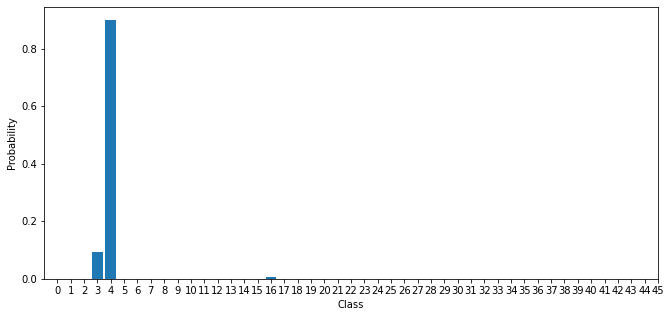

In [28]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [29]:
print(type(probability_3))
print(probability_3.shape)
print("index#:",probability_3.argmax(),"value:",probability_3[probability_3.argmax()])

<class 'numpy.ndarray'>
(46,)
index#: 4 value: 0.9003173006221439


In [30]:
model.predict(tfidfv_test[3])

array([4])

모델은 4번 클래스를 약 90%의 확률로 확신하는데, 10%의 확률로 3번 클래스라고 판단합니다. 90%의 확률로 확신하므로 모델이 예측한 레이블은 4번입니다. 해당 샘플은 정확하게 예측했네요.

>## (참고) 분류성능 평가지표 : F1-Score, Confusion Matrix, Accuracy

label이 불균형하면 accuracy를 믿을 수가 없어짐. 찍을수도 있기 때문. 이럴때는 F1-Score를 봐야함.

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

사이킷런의 metrics 패키지에서는 정밀도, 재현율, F1점수를 구하는 classification_report() 함수를 제공합니다. 이 함수는 각각의 클래스를 양성(positive) 클래스로 보았을 때의 정밀도, 재현율, F1점수를 각각 구하고 그 평균값으로 전체 모델의 성능을 평가합니다.

In [32]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

최종 결과에서 각각이 의미하는 바는 다음과 같습니다.

- macro: 단순평균
- weighted: 각 클래스에 속하는 표본의 개수로 가중평균
- accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율

In [33]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')


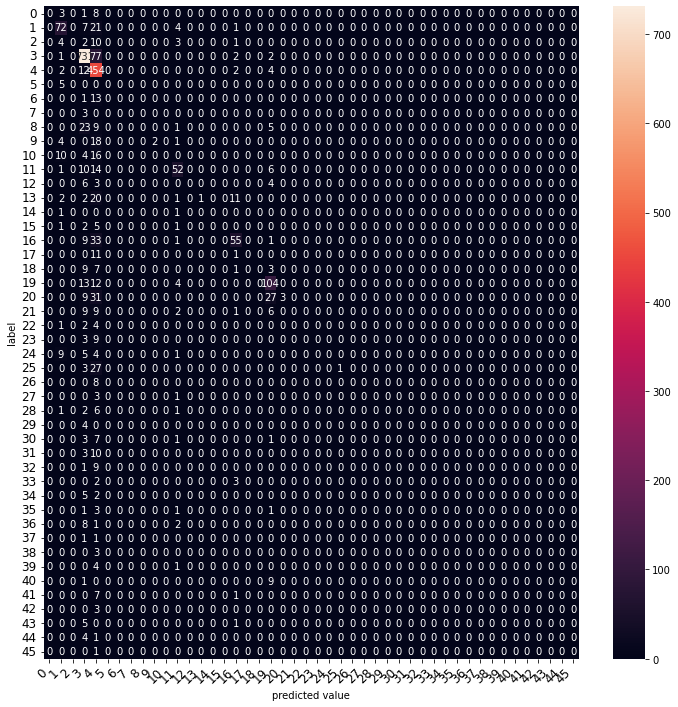

In [34]:
graph_confusion_matrix(model, tfidfv_test, y_test)

>## 2) 보완한 나이브 베이즈 분류기 Complement Naive Bayes Classifier(CNB)

앞서 사용한 나이브 베이즈 분류기(MultinomialNB)로는 약 66%의 정확도밖에 얻지 못했습니다. 사실 클래스의 개수가 46개인 것을 감안해도 그리 좋은 성능은 아닙니다. 좀 더 좋은 성능을 얻기 위해서 여러 다른 모델들을 시도해 봅시다.

나이브 베이지안 분류기는 독립 변수가 '조건부로 독립적'이라는 가정을 하기 때문에, 문서가 특정 분류에 속할 실제 확률을 사용할 때 문제가 발생할 수 있습니다. 예를 들어 많은 샘플(sample)이 특정 클래스에 치우쳐져 있을 경우, 결정 경계의 가중치가 한쪽으로 치우쳐져 모델이 특정 클래스를 선호할 수 있어요. 앞서 로이터 뉴스 데이터에서도 3번, 4번 클래스가 다른 클래스에 비해 상대적으로 많은 클래스를 갖고 있음을 확인했었죠.

데이터가 불균형할 경우를 대비해 나이브 베이즈 분류기를 보완한 것이 컴플리먼트 나이브 베이즈 분류기입니다. 컴플리먼트 나이브 베이즈 분류기는 데이터의 불균형을 고려하여 가중치를 부여하는 특징을 가지고 있습니다. 따라서 컴플리먼트 나이브 베이즈 분류기는 나이브 베이즈 분류기(MultinomialNB)보다 성능이 일반적으로 더 좋습니다.

In [35]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [36]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, cb.predict(tfidfv_test), zero_division=0))

정확도: 0.7707034728406055
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.64      0.88      0.74       105
           2       0.91      0.50      0.65        20
           3       0.91      0.89      0.90       813
           4       0.75      0.92      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.67      0.80         3
           8       0.50      0.13      0.21        38
           9       0.82      0.92      0.87        25
          10       0.96      0.80      0.87        30
          11       0.55      0.73      0.63        83
          12       0.00      0.00      0.00        13
          13       0.58      0.59      0.59        37
          14       0.00      0.00      0.00         2
          15       0.50      0.11      0.18         9
          16       0.67      0.79      0.73        99
   

>## 3) 로지스틱 회귀(Logistic Regression) = Softmax Regression

softmax로 다중분류하는 알고리즘

소프트맥스 함수는 클래스가 N개일 때, N차원의 벡터가 '각 클래스가 정답일 확률'을 표현하도록 정규화해주는 함수입니다. 예를 들어 위의 그림은 4차원의 벡터를 입력으로 받으면서 3개의 클래스를 가지는 경우의 소프트맥스 회귀의 동작 과정을 보여주고 있습니다. 3개의 클래스 중 1개의 클래스를 예측해야 하므로 소프트맥스 회귀의 출력은 3차원의 벡터고, 각 벡터의 차원은 특정 클래스일 확률입니다. 오차와 실제값의 차이를 줄이는 과정에서 가중치와 편향이 학습됩니다.

사이킷런에서 소프트맥스 회귀는 LogisticRegression()을 통해서 구현할 수 있습니다.

In [37]:
# 10분 정도 소요됩니다.
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [38]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, lr.predict(tfidfv_test), zero_division=0))

정확도: 0.8107747105966162
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.74      0.78      0.76       105
           2       0.70      0.70      0.70        20
           3       0.91      0.93      0.92       813
           4       0.80      0.87      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.68      0.71      0.69        38
           9       0.81      0.88      0.85        25
          10       0.93      0.87      0.90        30
          11       0.67      0.72      0.70        83
          12       0.62      0.38      0.48        13
          13       0.65      0.59      0.62        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.71      0.77      0.74        99
   

>## 4) Linear SVM (Linear Support Vector Machine)

많은 선형 분류 모델은 태생적으로는 이진 분류만을 지원하는 이진 분류 모델입니다. (위에서 설명한 로지스틱 회귀는 예외입니다.) 서포트 벡터 머신의 구현체인 사이킷런의 LinearSVC 또한 태생적으로는 이진 분류를 위한 모델입니다. 그런데 이진 분류 알고리즘을 다중 클래스 분류 알고리즘으로 사용하는 방법이 있습니다. 바로 일대다(one-vs.-rest 또는 one-vs.-all) 방법입니다. 일대다 방식은 각 클래스를 다른 모든 클래스와 구분하도록 이진 분류 모델을 학습시킵니다.

결국 클래스의 수만큼 이진 분류 모델이 만들어집니다. 예측할 때는 만들어진 모든 이진 분류기가 작동하여 가장 높은 점수를 내는 분류기의 클래스를 예측값으로 선택합니다. 서포트 벡터 머신을 사용하여 로이터 뉴스를 분류해 봅시다.

In [39]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [40]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, lsvc.predict(tfidfv_test), zero_division=0))

정확도: 0.786286731967943
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.73      0.72      0.73       105
           2       0.70      0.70      0.70        20
           3       0.91      0.91      0.91       813
           4       0.81      0.84      0.82       474
           5       0.00      0.00      0.00         5
           6       0.75      0.86      0.80        14
           7       1.00      0.67      0.80         3
           8       0.60      0.66      0.62        38
           9       0.78      0.84      0.81        25
          10       0.83      0.83      0.83        30
          11       0.67      0.77      0.72        83
          12       0.50      0.38      0.43        13
          13       0.54      0.59      0.56        37
          14       1.00      1.00      1.00         2
          15       0.60      0.33      0.43         9
          16       0.65      0.71      0.68        99
    

>## 5) Decision Tree

결정 트리는 분류와 회귀 문제에 널리 사용하는 모델입니다. 기본적으로 결정 트리는 결정에 다다르기 위해 '예/아니오' 질문을 이어 나가면서 학습합니다. 이 질문은 스무고개 놀이의 질문과 비슷합니다. 

사이킷런에서는 DecisionTreeClassifier()를 사용해서 결정 트리를 구현할 수 있습니다. 결정 트리의 깊이는 max_depth라는 인자를 통해서 정해줄 수 있습니다.

In [41]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [42]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, tree.predict(tfidfv_test), zero_division=0))

정확도: 0.6202137132680321
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.72      0.42      0.53       105
           2       0.62      0.50      0.56        20
           3       0.93      0.83      0.88       813
           4       0.40      0.90      0.56       474
           5       0.00      0.00      0.00         5
           6       0.90      0.64      0.75        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.88      0.88      0.88        25
          10       0.85      0.77      0.81        30
          11       0.64      0.51      0.56        83
          12       0.14      0.08      0.10        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.84      0.69        99
   

지금까지의 모델 중 가장 낮은 정확도인 62%를 얻습니다. 사실 트리 계열의 모델들은 고차원이고 희소한 데이터에 대해서는 성능이 나오지 않는다는 특징이 있습니다. DTM이나 TF-IDF 행렬의 경우 고차원이면서 대부분의 값이 0인 희소한 데이터이므로 트리 계열의 모델보다는 선형 분류 모델을 통해 접근하는 것이 더 나은 접근일 수 있습니다.

>## 6) Random Forest

앙상블(Ensemble) 이란 여러 머신러닝 모델을 연결하여 더 강력한 모델을 만드는 기법입니다. 뒤에서 보팅(Voting)이라는 앙상블 기법을 알아볼 텐데, 모델 자체가 앙상블을 사용하는 앙상블 모델들도 존재합니다. 랜덤 포레스트와 그래디언트 부스팅 트리는 결정 트리를 사용하는 앙상블 모델입니다.

결정 트리는 훈련 데이터에 과적합(Overfitting)되는 경향이 있습니다. 랜덤 포레스트는 이 문제를 앙상블로 해결합니다. 가령 서로 다른 방향으로 과적합된 트리들을 조합하면 오히려 모델 전체에서는 과적합을 피할 수 있다는 것이죠.

In [43]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [44]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, forest.predict(tfidfv_test), zero_division=0))

정확도: 0.674087266251113
              precision    recall  f1-score   support

           0       0.22      0.33      0.27        12
           1       0.45      0.77      0.57       105
           2       0.30      0.30      0.30        20
           3       0.82      0.90      0.86       813
           4       0.61      0.83      0.70       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.67      0.53      0.59        38
           9       0.70      0.28      0.40        25
          10       0.75      0.30      0.43        30
          11       0.55      0.59      0.57        83
          12       0.40      0.15      0.22        13
          13       0.37      0.19      0.25        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.59      0.59        99
    

>## 7) Gradient Boosting Classifier

그래디언트 부스팅 트리는 여러 개의 결정 트리를 묶어 만드는 앙상블 모델입니다. 그레디언트 부스팅은 랜덤 포레스트와 다르게 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듭니다.

그래디언트 부스팅 트리는 일부 특성을 무시한다는 특징을 가지고 있습니다. 그래서 보통 랜덤 포레스트를 먼저 사용해보고, 성능이나 예측 시간 면에서 만족스럽지 않은 경우에 그래디언트 부스팅 트리를 시도해보는 것이 좋습니다.

일반적으로 1 ~ 5 정도의 깊지 않은 트리를 사용하므로 메모리도 적게 사용하고 예측도 빠릅니다.

정확도도 준수하고, 특히 예측 속도가 빠르다는 점에서 데이터 경진 대회에서 많은 우승을 했던 모델입니다. 다만, 훈련 시간의 속도가 좀 오래 걸리고, 트리 기반 모델의 특성으로 인해서 희소한 고차원 데이터에 대해서는 잘 동작하지 않는다는 단점이 있습니다.

현재 우리가 사용하는 TF-IDF 행렬은 희소하고 고차원 데이터지만, 결정 트리나 랜덤 포레스트보다 더 높은 성능을 얻을 수 있을지 한번 테스트해 볼까요?

저는 아래 코드 실행에 약 12분 정도 소요되었습니다. verbose=3을 GradientBoostingClassifier안에 인자로 넣어 진행 상황을 확인할 수 있으니 참고해 주세요!

In [45]:
# 15분 정도 소요될 수 있습니다.
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [46]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, grbt.predict(tfidfv_test), zero_division=0))

정확도: 0.7662511130899377
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.77      0.68      0.72       105
           2       0.78      0.70      0.74        20
           3       0.88      0.91      0.89       813
           4       0.76      0.83      0.79       474
           5       0.50      0.20      0.29         5
           6       0.80      0.86      0.83        14
           7       1.00      0.33      0.50         3
           8       0.64      0.66      0.65        38
           9       0.74      0.80      0.77        25
          10       0.90      0.87      0.88        30
          11       0.62      0.64      0.63        83
          12       0.33      0.46      0.39        13
          13       0.62      0.49      0.55        37
          14       0.14      0.50      0.22         2
          15       0.38      0.33      0.35         9
          16       0.73      0.73      0.73        99
   

>## 8) Voting

사용한 ML 모델들을 유권자라고 하고, 각각의 답을 적어내서 최종 답을 뽑는것.
- 하드보팅 : 각 ML 모델들에게 투표용지를 한 장씩 줘서 투표하는 것. 모두 자신이 뽑아낸 predicted label (여기선 다중분류이니깐)이 카테고리 숫자를 써내고, 그중에 가장 많은 표를 받은 것이 답이됨.
- 소프트보팅 : 각 모델이 라벨을 계산하게 된 근거, 즉 그럴 확률이 다들 있음. predicted_proba 함수를 통해 최종 결과가 나올 확률값을 다 더하고, 최종 결과물에 대한 각각의 확률을 구한 뒤에 최종값을 도출함.

이전에 사용했던 세 가지 모델인 로지스틱 회귀, CNB, 그래디언트 부스팅 트리를 사용하여 소프트 보팅을 하였을 때의 성능을 비교해 봅시다.

In [47]:
# 20분 이상 소요될 수 있습니다.
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [48]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, voting_classifier.predict(tfidfv_test), zero_division=0))

정확도: 0.8165627782724845
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.78      0.77      0.78       105
           2       0.80      0.80      0.80        20
           3       0.92      0.94      0.93       813
           4       0.82      0.87      0.85       474
           5       1.00      0.20      0.33         5
           6       0.86      0.86      0.86        14
           7       1.00      0.33      0.50         3
           8       0.68      0.68      0.68        38
           9       0.81      0.84      0.82        25
          10       0.96      0.90      0.93        30
          11       0.68      0.70      0.69        83
          12       0.46      0.46      0.46        13
          13       0.69      0.65      0.67        37
          14       0.14      0.50      0.22         2
          15       0.57      0.44      0.50         9
          16       0.73      0.75      0.74        99
   

# 빈도수 상위 5000개의 단어만 사용하기

In [49]:
# 데이터 불러오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

# 데이터 복원
word_index = reuters.get_word_index()
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>","<sos>","<unk>")):
    index_to_word[index]=token   

decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
x_train = decoded
print("x_train 데이터 갯수 :",len(x_train))

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)
x_test = decoded
print("x_test 데이터 갯수 :",len(x_test))

# train 벡터화 (DTM)
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

x_train 데이터 갯수 : 8982
x_test 데이터 갯수 : 2246


In [50]:
# 1. 나이브 베이즈 분류기
model = MultinomialNB()
model.fit(tfidfv, y_train)
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환
predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("NB 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

NB 정확도: 0.6731967943009796
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99


In [51]:
# 2. 보완된 나이브 베이즈 분류기
cb = ComplementNB()
cb.fit(tfidfv, y_train)
predicted = cb.predict(tfidfv_test)
print("CNB 정확도:", accuracy_score(y_test, predicted))
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

CNB 정확도: 0.7707034728406055
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99

In [52]:
# 3. Softmax 회귀
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)  
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) 
print("Softmax 정확도:", accuracy_score(y_test, predicted))
print(classification_report(y_test, lr.predict(tfidfv_test), zero_division=0))

Softmax 정확도: 0.8036509349955476
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.77      0.75       105
           2       0.76      0.80      0.78        20
           3       0.90      0.93      0.91       813
           4       0.80      0.86      0.83       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.66      0.71      0.68        38
           9       0.81      0.88      0.85        25
          10       0.89      0.83      0.86        30
          11       0.64      0.73      0.69        83
          12       0.57      0.31      0.40        13
          13       0.63      0.65      0.64        37
          14       0.50      0.50      0.50         2
          15       0.75      0.33      0.46         9
          16       0.70      0.75      0.73      

In [53]:
# 3-1. Softmax 회귀
lr = LogisticRegression(C=5000, penalty='l2', max_iter=3000)  # C 10000>>5000
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) 
print("Softmax 정확도:", accuracy_score(y_test, predicted))

Softmax 정확도: 0.8067675868210151


In [54]:
# 3-2. Softmax 회귀
lr = LogisticRegression(C=15000, penalty='l2', max_iter=3000)  # C 10000>>15000
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) 
print("Softmax 정확도:", accuracy_score(y_test, predicted))

Softmax 정확도: 0.8032056990204809


In [55]:
# 4. Linear SVM
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)
predicted = lsvc.predict(tfidfv_test) 
print("Linear SVM 정확도:", accuracy_score(y_test, predicted)) 
print(classification_report(y_test, lsvc.predict(tfidfv_test), zero_division=0))

Linear SVM 정확도: 0.7751558325912734
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.68      0.71      0.69       105
           2       0.73      0.80      0.76        20
           3       0.90      0.90      0.90       813
           4       0.80      0.84      0.82       474
           5       0.00      0.00      0.00         5
           6       0.88      1.00      0.93        14
           7       1.00      0.67      0.80         3
           8       0.59      0.63      0.61        38
           9       0.81      0.84      0.82        25
          10       0.85      0.77      0.81        30
          11       0.63      0.72      0.67        83
          12       0.44      0.31      0.36        13
          13       0.60      0.65      0.62        37
          14       0.50      1.00      0.67         2
          15       0.67      0.22      0.33         9
          16       0.64      0.71      0.67   

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [56]:
# 4-1. Linear SVM
lsvc = LinearSVC(C=1500, penalty='l1', max_iter=3000, dual=False) #C 1000>>1500
lsvc.fit(tfidfv, y_train)
predicted = lsvc.predict(tfidfv_test) 
print("Linear SVM 정확도:", accuracy_score(y_test, predicted)) 

Linear SVM 정확도: 0.7720391807658059


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [57]:
# 5. Decision Tree
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)
predicted = tree.predict(tfidfv_test)
print("DT 정확도:", accuracy_score(y_test, predicted))
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

DT 정확도: 0.6179875333926982
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.50      0.80      0.62       105
           2       0.00      0.00      0.00        20
           3       0.86      0.89      0.87       813
           4       0.59      0.95      0.73       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.28      0.44        25
          10       0.00      0.00      0.00        30
          11       0.48      0.73      0.58        83
          12       0.00      0.00      0.00        13
          13       1.00      0.14      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.60      0.66      0.62        99


In [58]:
# 6. Random Forest
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)
predicted = forest.predict(tfidfv_test) 
print("RF 정확도:", accuracy_score(y_test, predicted))
print(classification_report(y_test, forest.predict(tfidfv_test), zero_division=0))

RF 정확도: 0.701246660730187
              precision    recall  f1-score   support

           0       0.28      0.42      0.33        12
           1       0.42      0.78      0.55       105
           2       0.44      0.35      0.39        20
           3       0.84      0.90      0.87       813
           4       0.68      0.84      0.75       474
           5       0.00      0.00      0.00         5
           6       0.86      0.43      0.57        14
           7       1.00      0.33      0.50         3
           8       0.59      0.53      0.56        38
           9       0.71      0.40      0.51        25
          10       0.89      0.53      0.67        30
          11       0.57      0.69      0.62        83
          12       0.33      0.15      0.21        13
          13       0.46      0.32      0.38        37
          14       0.00      0.00      0.00         2
          15       1.00      0.11      0.20         9
          16       0.70      0.67      0.68        99
 

In [59]:
# 7. Gradient Boosting Classifier
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)
predicted = grbt.predict(tfidfv_test) 
print("GBC 정확도:", accuracy_score(y_test, predicted))
print(classification_report(y_test, grbt.predict(tfidfv_test), zero_division=0))

GBC 정확도: 0.767586821015138
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.80      0.68      0.73       105
           2       0.70      0.70      0.70        20
           3       0.90      0.90      0.90       813
           4       0.76      0.83      0.79       474
           5       0.14      0.20      0.17         5
           6       0.93      0.93      0.93        14
           7       0.50      0.33      0.40         3
           8       0.64      0.66      0.65        38
           9       0.91      0.84      0.87        25
          10       0.87      0.87      0.87        30
          11       0.62      0.66      0.64        83
          12       0.46      0.46      0.46        13
          13       0.55      0.43      0.48        37
          14       0.08      0.50      0.14         2
          15       0.33      0.22      0.27         9
          16       0.72      0.77      0.75        99


In [60]:
# 8. Voting
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),#C 10000>5000
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)
predicted = voting_classifier.predict(tfidfv_test)
print("Voting 정확도:", accuracy_score(y_test, predicted))
print(classification_report(y_test, voting_classifier.predict(tfidfv_test), zero_division=0))

Voting 정확도: 0.8103294746215495
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.79      0.73      0.76       105
           2       0.65      0.65      0.65        20
           3       0.91      0.94      0.92       813
           4       0.82      0.87      0.84       474
           5       0.50      0.20      0.29         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.68      0.68      0.68        38
           9       0.78      0.84      0.81        25
          10       0.93      0.87      0.90        30
          11       0.67      0.72      0.70        83
          12       0.60      0.46      0.52        13
          13       0.65      0.65      0.65        37
          14       0.10      0.50      0.17         2
          15       0.60      0.33      0.43         9
          16       0.75      0.75      0.75       

In [61]:
# 8-1. Voting
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=15000, max_iter=3000, penalty='l2')),#C 10000>15000
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)
predicted = voting_classifier.predict(tfidfv_test)
print("Voting 정확도:", accuracy_score(y_test, predicted))

Voting 정확도: 0.8098842386464826


NB 정확도: 0.6731967943009796  
CNB 정확도: 0.7707034728406055  
Softmax 정확도: 0.8036509349955476 (C=10000)  
Softmax 정확도: 0.8067675868210151 (C=5000)  
Softmax 정확도: 0.8032056990204809 (C=15000)  
Linear SVM 정확도: 0.7724844167408726 (C=1000)  
Linear SVM 정확도: 0.7742653606411398 (C=1500)  
DT 정확도: 0.6179875333926982  
RF 정확도: 0.701246660730187  
GBC 정확도: 0.767586821015138  
<mark>Voting 정확도: 0.8103294746215495 (C=10000) </mark>   
Voting 정확도: 0.8098842386464826 (C=15000)

# 딥러닝으로 해보기 1

- 재복원된 train+test를 합쳐서 토크나이징과 인덱싱을 하고
- 패딩은 post, maxlen =400 (ml과 동일)
- 임베딩 들어가기 전 다시 train과 test를 그전과 동일하게 8:2로 슬라이싱
- 여러가지 딥러닝 하기에 수행했음


In [62]:
# train + test 데이터 합치기
print(type(x_train))
print(len(x_train))
print(len(x_test))
data = x_train + x_test
print(len(data))
print(data[0])

<class 'list'>
8982
2246
11228
<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [63]:
# data tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, filters=' ', oov_token="<unk>")
tokenizer.fit_on_texts(data)
tensor = tokenizer.texts_to_sequences(data)

print(tensor[0])

[16, 2, 2, 7, 43, 9, 447, 4, 25, 207, 270, 4, 3082, 111, 15, 368, 186, 90, 67, 6, 89, 4, 19, 102, 5, 19, 124, 14, 90, 67, 84, 22, 480, 26, 6, 48, 3, 49, 7, 862, 39, 209, 154, 5, 151, 5, 83, 10, 14, 22, 155, 10, 14, 6, 48, 8, 4553, 1005, 503, 5, 258, 5, 272, 10, 14, 22, 134, 44, 10, 14, 15, 7, 197, 1244, 90, 67, 52, 29, 209, 30, 32, 132, 5, 109, 14, 17, 11]


In [64]:
# 해당 길이 몇프로인지 확인하는 함수

def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list)) * 100)) 

In [65]:
# maxlen

maxlen = 400
below_threshold_len(maxlen, tensor)

전체 샘플 중 길이가 400 이하인 샘플의 비율: 93.38261489134308


In [66]:
# 패딩하기

tensor = pad_sequences(tensor,maxlen=maxlen)
print(tensor[0])
print(type(tensor))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [67]:
# 토큰화, 인코딩 후 데이터셋 다시 나누기 
x_train = tensor[:8982]
x_test = tensor[8982:]
print(x_train.shape)
print(x_test.shape)
print(type(y_train))
# print(x_train[0])
# print(x_test[0])

(8982, 400)
(2246, 400)
<class 'numpy.ndarray'>


>## 1. Emb + LSTM(128) + Dense(46) -> test acc : 0.68

In [68]:
# 모델링하기
from tensorflow.keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         500000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 46)                5934      
Total params: 623,182
Trainable params: 623,182
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])

Epoch 1/30
113/113 [==============================] - 6s 23ms/step - loss: 2.2866 - acc: 0.4209 - val_loss: 2.0045 - val_acc: 0.4802
Epoch 2/30
113/113 [==============================] - 2s 19ms/step - loss: 1.8428 - acc: 0.5219 - val_loss: 1.7418 - val_acc: 0.5326
Epoch 3/30
113/113 [==============================] - 2s 20ms/step - loss: 1.6851 - acc: 0.5646 - val_loss: 1.7871 - val_acc: 0.5492
Epoch 4/30
113/113 [==============================] - 2s 19ms/step - loss: 1.5619 - acc: 0.5882 - val_loss: 1.5866 - val_acc: 0.5993
Epoch 5/30
113/113 [==============================] - 2s 20ms/step - loss: 1.4626 - acc: 0.6184 - val_loss: 1.5223 - val_acc: 0.6305
Epoch 6/30
113/113 [==============================] - 2s 19ms/step - loss: 1.3295 - acc: 0.6514 - val_loss: 1.4016 - val_acc: 0.6528
Epoch 7/30
113/113 [==============================] - 2s 19ms/step - loss: 1.2267 - acc: 0.6777 - val_loss: 1.4293 - val_acc: 0.6411
Epoch 8/30
113/113 [==============================] - 2s 19ms/step - 

In [70]:
# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

71/71 [==============================] - 0s 7ms/step - loss: 1.5604 - acc: 0.6425
Test accuracy: 0.6424754858016968


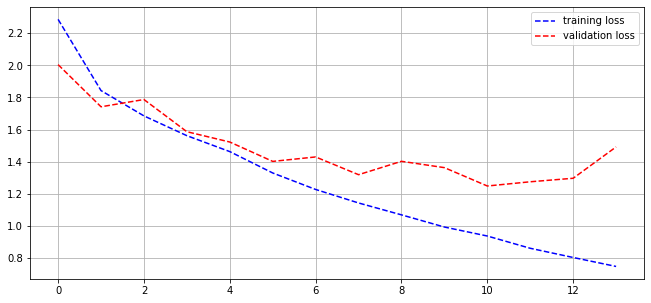

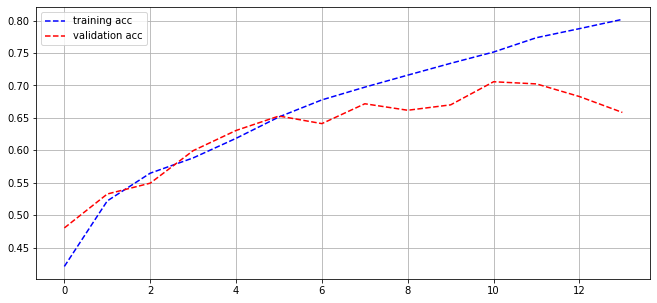

In [71]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

>## 2. Emb + LSTM(128) + BatNorm + LSTM(128) + BatNorm +Dense(46) -> test acc : 0.56

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128)         512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 755,790
Trainable params: 755,278
Non-trainable params: 512
______________________________________________

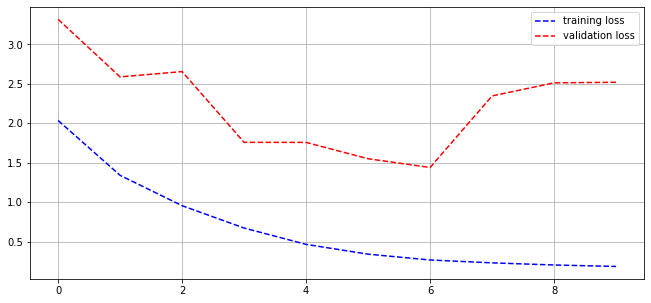

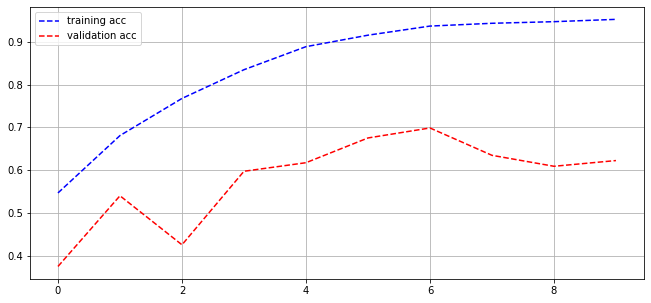

In [72]:
# 모델링하기
from tensorflow.keras.layers import Embedding, Dense, LSTM, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(hidden_units))
model.add(BatchNormalization())
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Graph
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

>## 3. Emb + LSTM(128) + BatNorm + Dropout(0.2) + LSTM(128) + BatNorm + Dropout(0.2) + Dense(46) -> test acc : 0.45

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         117248    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128)         512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)              

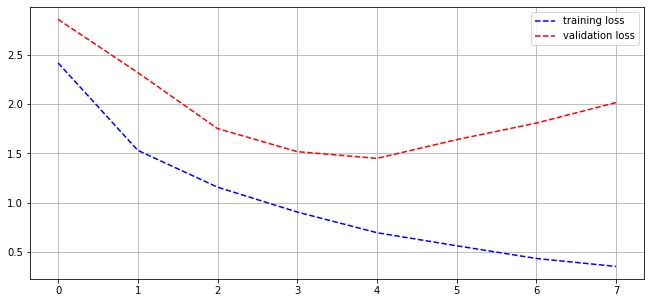

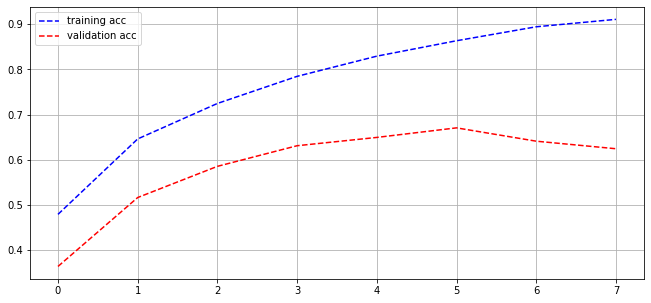

In [73]:
# 모델링하기
from tensorflow.keras.layers import Embedding, Dense, LSTM, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(hidden_units))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Graph
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

>## 4. Emb + LSTM(300) + Dense(46) -> test acc : 0.68

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 46)                5934      
Total params: 1,725,582
Trainable params: 1,725,582
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
113/113 [==============================] - 4s 27ms/step - loss: 2.1793 - acc: 0.4433 - val_loss: 1.8757 - val_acc: 0.5070
Epoch 2/30
113/113 [==============================] - 3s 25ms/step - loss: 1.7004 - acc: 0.5609 - val_loss: 1.7255 - val_acc: 0.5314
Epoch 3/30
113/113 [==============================] - 3s 24ms/step - loss: 1.4912 - acc: 0.6264 - val_loss: 

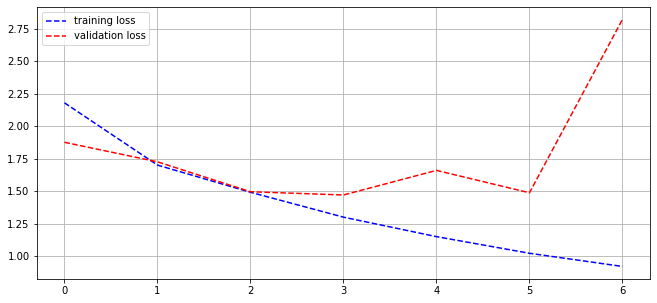

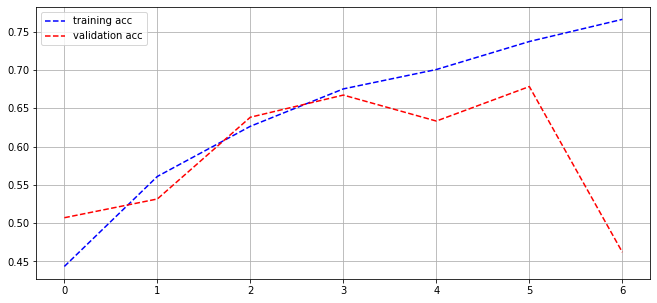

In [74]:
# 모델링하기
from tensorflow.keras.layers import Embedding, Dense, LSTM, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 300
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Graph
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

>## 5. Emb + GApooling1D + Dense(46) -> test acc : 0.78

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 46)                4646      
Total params: 504,646
Trainable params: 504,646
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
113/113 [==============================] - 1s 4ms/step - loss: 3.1152 - acc: 0.3538 - val_loss: 2.4218 - val_acc: 0.3450
Epoch 2/50
113/113 [==============================] - 0s 3ms/step - loss: 2.3102 - acc: 0.3641 - val_loss: 2.2465 - val_acc: 0.3645
Epoch 3/50
113/113 [==============================] - 0s 3ms/step - loss: 2.2119 - acc: 0.3795 - val_loss: 2.1631 

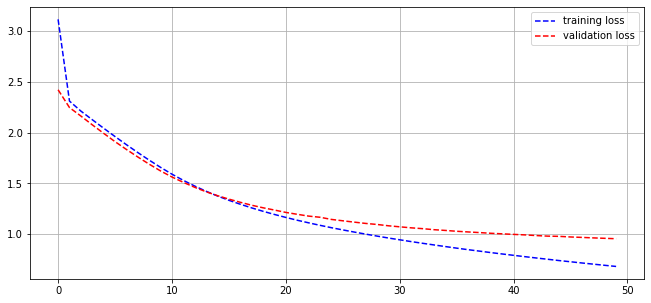

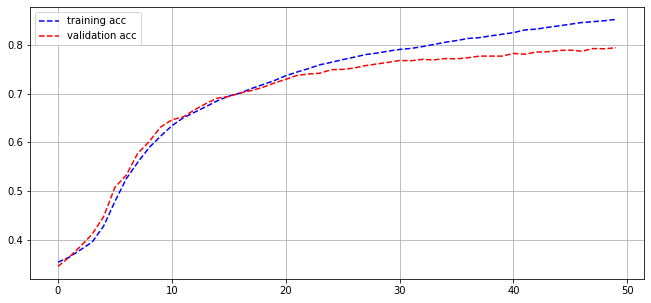

In [75]:
# 모델링하기
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GlobalAveragePooling1D())
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Graph
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()

1. Emb + LSTM(128) + Dense(46) -> test acc : 0.68
2. Emb + LSTM(128) + BatNorm + LSTM(128) + BatNorm +Dense(46) -> test acc : 0.56
3. Emb + LSTM(128) + BatNorm + Dropout(0.2) + LSTM(128) + BatNorm + Dropout(0.2) + Dense(46) -> test acc : 0.45
4. Emb + LSTM(300) + Dense(46) -> test acc : 0.68    
5. Emb + GApooling1D + Dense(46) -> test acc : 0.78

- 레이어가 깊을수록 결과가 좋지않고, lstm보다 pooling1d가 결과가 더 좋아서 당황.. 
- maxlen=100, padding을 post가 아닌 past에 둬보기로 함.

>> ## 레이어 구조 : 1층 lstm, 데이터셋 : 원본 그대로 Solid

>> ## 1. maxlen = 100, padding=post >> Test_acc = 0.66

In [76]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
maxlen = 100
x_train = pad_sequences(x_train,maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test,maxlen=maxlen, padding='post')
print(x_train[0])

[   1    2    2    8   43   10  447    5   25  207  270    5 3095  111
   16  369  186   90   67    7   89    5   19  102    6   19  124   15
   90   67   84   22  482   26    7   48    4   49    8  864   39  209
  154    6  151    6   83   11   15   22  155   11   15    7   48    9
 4579 1005  504    6  258    6  272   11   15   22  134   44   11   15
   16    8  197 1245   90   67   52   29  209   30   32  132    6  109
   15   17   12    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 46)                5934      
Total params: 623,182
Trainable params: 623,182
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
113/113 [==============================] - 2s 11ms/step - loss: 2.3950 - acc: 0.3640 - val_loss: 2.1999 - val_acc: 0.4062
Epoch 2/30
113/113 [==============================] - 1s 7ms/step - loss: 2.1102 - acc: 0.4299 - val_loss: 2.0984 - val_acc: 0.3701
Epoch 3/30
113/113 [==============================] - 1s 8ms/step - loss: 1.8983 - acc: 0.4853 - val_loss: 2.0450

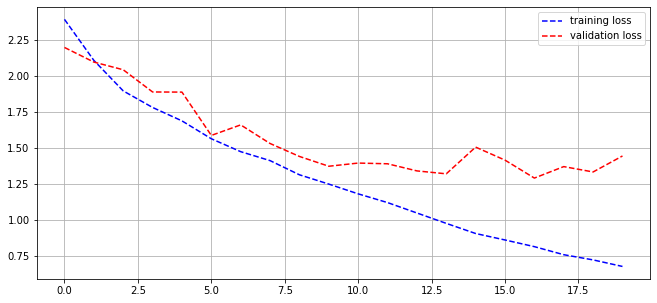

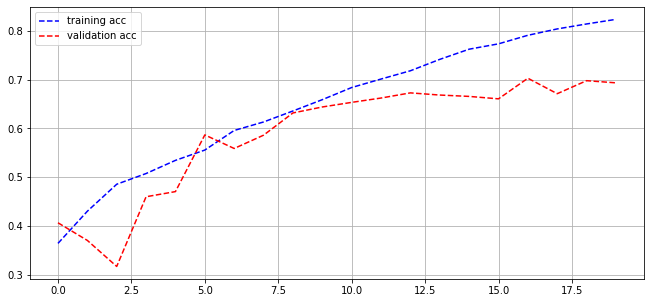

In [77]:
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
#######
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()   # 0.66

>>## 2. maxlen=400, padding=post >> Test_acc : 0.37

[   1    2    2    8   43   10  447    5   25  207  270    5 3095  111
   16  369  186   90   67    7   89    5   19  102    6   19  124   15
   90   67   84   22  482   26    7   48    4   49    8  864   39  209
  154    6  151    6   83   11   15   22  155   11   15    7   48    9
 4579 1005  504    6  258    6  272   11   15   22  134   44   11   15
   16    8  197 1245   90   67   52   29  209   30   32  132    6  109
   15   17   12    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

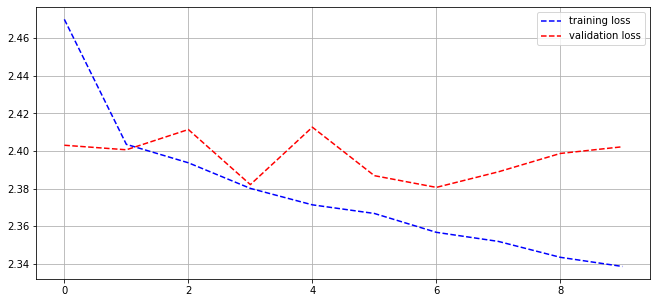

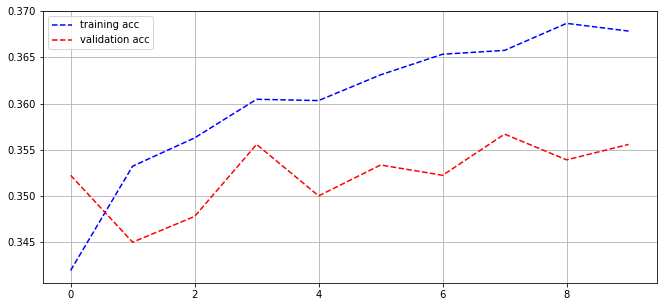

In [78]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
maxlen = 400
x_train = pad_sequences(x_train,maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test,maxlen=maxlen, padding='post')
print(x_train[0])

from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
#######
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()   # 0.37

>## maxlen=400, Emb + LSTM(128) + Dense(46)로 Solid

[   1    2    2    8   43   10  447    5   25  207  270    5 3095  111
   16  369  186   90   67    7   89    5   19  102    6   19  124   15
   90   67   84   22  482   26    7   48    4   49    8  864   39  209
  154    6  151    6   83   11   15   22  155   11   15    7   48    9
 4579 1005  504    6  258    6  272   11   15   22  134   44   11   15
   16    8  197 1245   90   67   52   29  209   30   32  132    6  109
   15   17   12    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

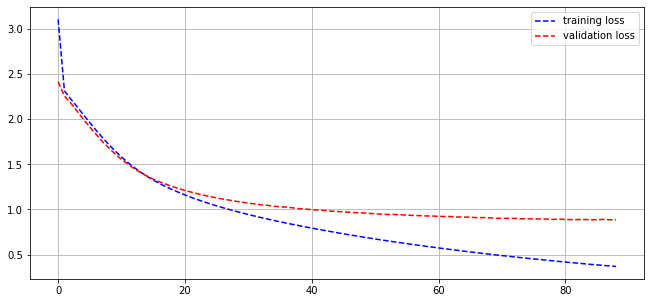

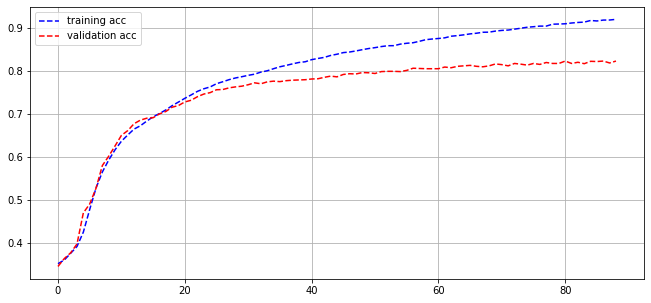

In [79]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
maxlen = 400
x_train = pad_sequences(x_train,maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test,maxlen=maxlen, padding='post')
print(x_train[0])

from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GlobalAveragePooling1D())
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_split=0.2, callbacks=[early_stop])
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
#######
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()   # epoch30 : 0.74 / 50 : 0.78 / 86 : 0.80

>> # dense 추가 실험

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_9 (Dense)              (None, 46)                2990      
Total params: 509,454
Trainable params: 509,454
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
113/113 [==============================] - 1s 4ms/step - loss: 2.7286 - acc: 0.3502 - val_loss: 2.2920 - val_acc: 0.3534
Epoch 2/500
113/113 [==============================] - 0s 3ms/step - loss: 2.2309 - acc: 0.3677 - val_loss: 2.147

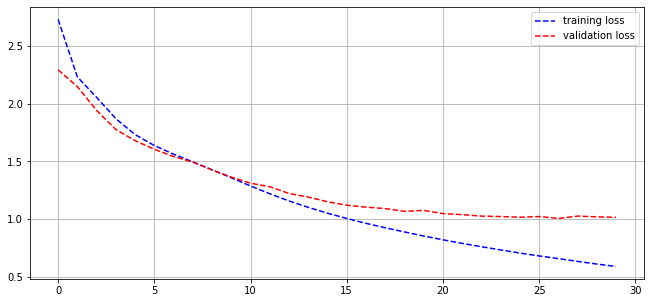

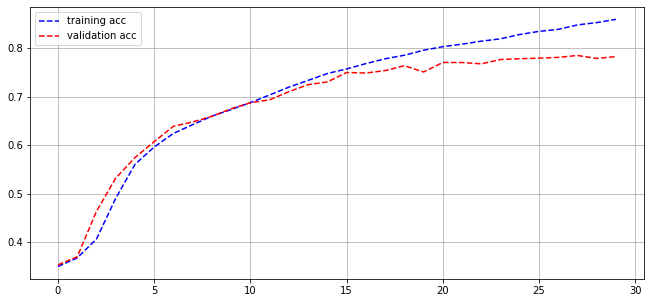

In [80]:
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation ='relu'))
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_split=0.2, callbacks=[early_stop])
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
#######
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()   # + dense64 :0.77

>>## Bidirectional LSTM 1층 

[   1    2    2    8   43   10  447    5   25  207  270    5 3095  111
   16  369  186   90   67    7   89    5   19  102    6   19  124   15
   90   67   84   22  482   26    7   48    4   49    8  864   39  209
  154    6  151    6   83   11   15   22  155   11   15    7   48    9
 4579 1005  504    6  258    6  272   11   15   22  134   44   11   15
   16    8  197 1245   90   67   52   29  209   30   32  132    6  109
   15   17   12    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

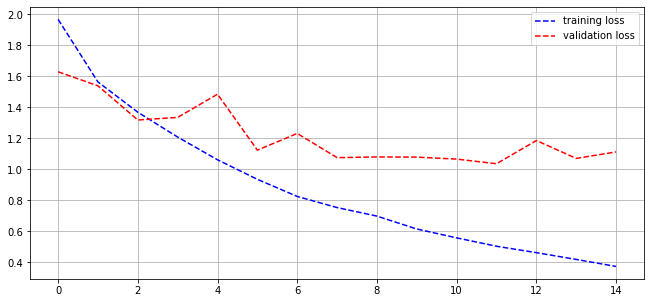

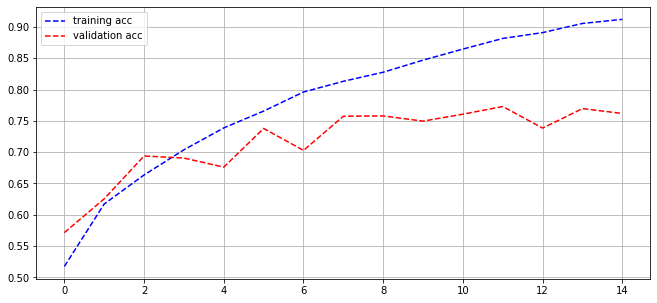

In [81]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
maxlen = 400
x_train = pad_sequences(x_train,maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test,maxlen=maxlen, padding='post')
print(x_train[0])

from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, BatchNormalization, Dropout,Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
#######
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()   # 0.73

>>## Bidirectional LSTM + Dropout 0.5

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         500000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 46)                11822     
Total params: 746,318
Trainable params: 746,318
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
113/113 [==============================] - 7s 41ms/step - loss: 2.0388 - acc: 0.4866 - val_loss: 1.6837 - val_acc: 0.5732
Epoch 2/30
113/113 [==============================] - 4s 35ms/step - loss: 1.6404 - acc: 0.5887 - val_loss: 1.74

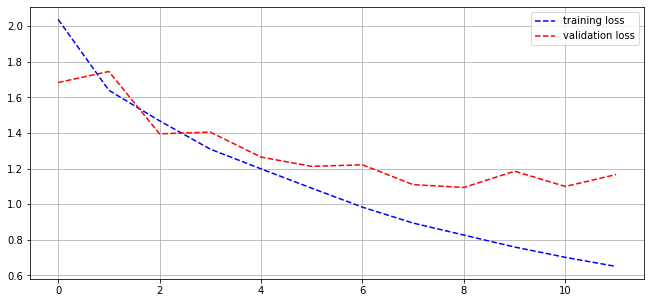

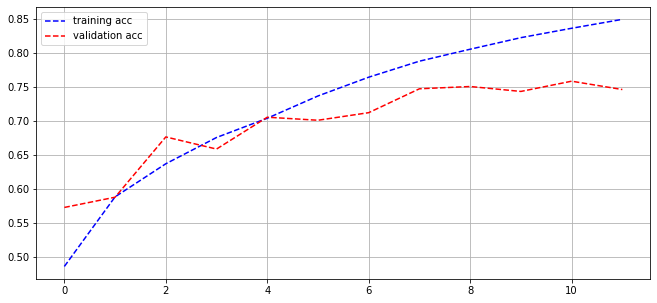

In [82]:
embedding_dim = 100
hidden_units = 128
vocab_size = 5000

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dropout(0.5))
model.add(Dense(46, activation ='softmax'))

model.compile(optimizer='rmsprop',
              loss = "sparse_categorical_crossentropy",
              metrics = ['acc'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stop])
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
#######
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss,'b--', label = 'training loss')
plt.plot(val_loss,'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc,'b--', label = 'training acc')
plt.plot(val_acc,'r--', label = 'validation acc')
plt.legend()
plt.grid()   # 0.69

num_words = 10000,

나이브 베이즈 분류기 (NB) : 0.66  
보완된 나이브 분류기 (CNB): 0.77  
softmax 분류기 : 0.81  
Linear SVM : 0.78     
Decision Tree : 0.62  
Random Forest : 0.67  
Gradient Boosting Classifier (GBC) : 0.76  
<mark>Voting : 0.81</mark>

num_words = 5000,  

NB 정확도: 0.6731967943009796  
CNB 정확도: 0.7707034728406055  
Softmax 정확도: 0.8036509349955476 (C=10000)  
Softmax 정확도: 0.8067675868210151 (C=5000)  
Softmax 정확도: 0.8032056990204809 (C=15000)  
Linear SVM 정확도: 0.7724844167408726 (C=1000)  
Linear SVM 정확도: 0.7742653606411398 (C=1500)  
DT 정확도: 0.6179875333926982  
RF 정확도: 0.701246660730187  
GBC 정확도: 0.767586821015138  
<mark>Voting 정확도: 0.8103294746215495 (C=10000)</mark>  
Voting 정확도: 0.8098842386464826 (C=15000)  

     - num_words가 줄어들면 규제의 C 파라미터를 늘려야한다고 해서 줄여도 늘려도 봤지만 아주 큰 변화는 찾기 힘들었다. 
     - num_words의 수를 10000 -> 5000으로 줄였으나, 거의 비슷한 정확도가 나왔으며 두 경우 모두 voting이 가장 우수하였다.
     
- F1 score가 머신러닝 기법별로 조금 다른 것을 확인했다. 공통적으로 Precision이 Recall보다 조금씩 높게 나오기는 했지만, 데이터의 종류에 따라 precision이나 recall이 중요한가에 따라 모델을 선택하는 기준이 달라질 듯 하다.

- num_words = 5000, DL
1. Emb + LSTM(128) + Dense(46) -> test acc : 0.68
2. Emb + LSTM(128) + BatNorm + LSTM(128) + BatNorm +Dense(46) -> test acc : 0.56
3. Emb + LSTM(128) + BatNorm + Dropout(0.2) + LSTM(128) + BatNorm + Dropout(0.2) + Dense(46) -> test acc : 0.45
4. Emb + LSTM(300) + Dense(46) -> test acc : 0.68    
5. Emb + GApooling1D + Dense(46) -> test acc : 0.78 **

    - LSTM 층이 깊을수록 좋지않다.
    - 그래서 1층 lstm만 쌓고, maxlen와 padding을 조절하여 
- 레이어 구조 : 1층 lstm, 데이터셋 : 원본 그대로 Solid
1. maxlen=100, padding=post >> Test_acc = 0.66
2. maxlen=400, padding=post >> Test_acc : 0.37

- Emb + GApooling1D + Dense(46)로 Solid
1. epoch 30 : 0.74   
2. epoch 50 : 0.78 **   

<mark> 3. epoch 86 : 0.80 </mark>

Emb + GApooling1D + Dense(64) + Dense(46)  
1. epoch 29 : 0.77 **

BidirectionalLSTM
1. Emb + BidirectionalLSTM(128) + Dense(46) >> 0.73
2. Emb + BidirectionalLSTM(128) + Dropout(0.5) + Dense(46) >> 0.69


딥러닝으로 돌린 결과가 머신러닝 결과보다 좋지가 않아서..기분이 좋지 않았다.
오늘 케창딥을 하면서 양방향 LSTM도 추가하였는데, 딱히 괄목할만한 결과가 없었다.
왜그런지 모르겠는데,, 데이터가 garbage라고 하기에는 ML이 잘나와서 구조의 문제인 것 같다.

여튼 내가 한 실험으로는,  
적어도 이 데이터에 있어서만큼은,  
층이 깊을수록 안좋았고,
LSTM보다는 그냥 단순한 gepooling1D가 더 좋았다.

트랜스포머에도 넣어보고 싶다. 
DL이 ML에게 진 것 같아서 성에 안찬다.. ㅜㅜ

평가문항	상세기준
1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?

3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?

Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?

동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.